# Peer-graded Assignment: Week 5: GANs

## Author: Tung Anh Nguyen Sy

#### About:

GANs are a widely used, fun and important family of deep learning based algorithms. A good starting point for learning how GANs work is the following [kaggle competition](https://www.kaggle.com/competitions/gan-getting-started):

> **"I’m Something of a Painter Myself"**
> 
> A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.
>
> The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.
>
> Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

The dataset consists of Monet paintings and photo images. The goal is to modify given photo images in a way that they look like paintings from Monet.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets as KD
import matplotlib.pyplot as plt
import numpy as np
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
autoTone = tf.data.experimental.AUTOTUNE   
print(tf.__version__)

2023-01-09 10:47:46.176434: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-09 10:47:46.176548: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Device: grpc://10.0.0.2:8470


2023-01-09 10:47:51.187823: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-09 10:47:51.190282: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-09 10:47:51.190321: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-09 10:47:51.190350: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b030d76c6bec): /proc/driver/nvidia/version does not exist
2023-01-09 10:47:51.192793: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


#### EDA:

The dataset comes in form of TensorFlows native TFRecord files. In total, 300 Monet paintings and roughly 7000 images are included in the dataset. Both painting and images are 256x256 by size and RGB images (i.e. of shape [256,256,3]).

In [2]:
PATH = KD().get_gcs_path()

MONET_FILES = tf.io.gfile.glob(str(PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILES = tf.io.gfile.glob(str(PATH + '/photo_tfrec/*.tfrec'))

print('Number of Monet Files:', 
      len(MONET_FILES))
print("Number of Monet Images:", 
      sum(1 for img in tf.data.TFRecordDataset(MONET_FILES)))
print('Number of Photo Files:', len(PHOTO_FILES))
print("Number of Photo Images:", 
      sum(1 for img in tf.data.TFRecordDataset(PHOTO_FILES)))

2023-01-09 10:47:56.915692: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-09 10:47:56.994434: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Number of Monet Files: 5
Number of Monet Images: 300
Number of Photo Files: 20


2023-01-09 10:47:58.724004: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 315, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673261278.720706855","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 315, Output num: 0","grpc_status":3}


Number of Photo Images: 7038


In [3]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
BATCH_SIZE = 16
N_CHANNELS = 3

def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=N_CHANNELS)
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    img = tf.reshape(img, [IMAGE_WIDTH, IMAGE_HEIGHT, N_CHANNELS])
    return img

def read_tfrecord(exm):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    exm = tf.io.parse_single_example(exm, tfrecord_format)
    img = decode_image(exm['image'])
    return img

def load_dataset(fileNames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(fileNames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autoTone)
    return dataset

In [4]:
MonetDS = load_dataset(MONET_FILES, labeled=True).batch(1)
PhotoDS = load_dataset(PHOTO_FILES, labeled=True).batch(1)

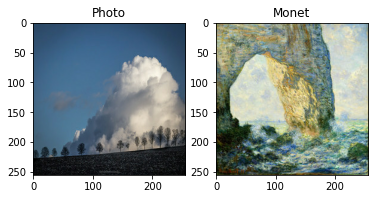

In [5]:
MonetExample = next(iter(MonetDS))
PhotoExample = next(iter(PhotoDS))

plt.subplot(121)
plt.title('Photo')
plt.imshow(PhotoExample[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(MonetExample[0] * 0.5 + 0.5)

#### Model:

In [6]:
outputChannels = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gammaInit = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gammaInit))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gammaInit = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gammaInit))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [7]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])
    downStack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4), 
        downsample(256, 4), 
#        downsample(512, 4), 
#        downsample(512, 4), 
#        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
    ]

    upStack = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
#        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4), 
#        upsample(256, 4),
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(outputChannels, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs
    
    skips = []
    
    for down in downStack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(upStack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [8]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gammaInit = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zeroPad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zeroPad1) 

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gammaInit)(conv)

    leakyRelu = layers.LeakyReLU()(norm1)

    zeroPad2 = layers.ZeroPadding2D()(leakyRelu) 

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zeroPad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [9]:
with strategy.scope():
    monetGenerator = Generator() 
    photoGenerator = Generator() 

    monetDiscriminator = Discriminator() 
    photoDiscriminator = Discriminator()

In [10]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monetGenerator,
        photoGenerator,
        monetDiscriminator,
        photoDiscriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monetGenerator
        self.p_gen = photoGenerator
        self.m_disc = monetDiscriminator
        self.p_disc = photoDiscriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

#### Training, Results and Analysis:

In [11]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [12]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [13]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [14]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [15]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [16]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monetGenerator, photoGenerator, monetDiscriminator, photoDiscriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [17]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((MonetDS, PhotoDS)),
    epochs=30
)

Epoch 1/30
300/300 [==============================] - 117s 146ms/step - monet_gen_loss: 5.0974 - photo_gen_loss: 5.2540 - monet_disc_loss: 0.6513 - photo_disc_loss: 0.6362
Epoch 2/30
  1/300 [..............................] - ETA: 59s - monet_gen_loss: 3.1218 - photo_gen_loss: 2.8143 - monet_disc_loss: 0.5567 - photo_disc_loss: 0.6600

2023-01-09 10:50:17.282072: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 17262, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673261417.281982499","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 17262, Output num: 1","grpc_status":3}


300/300 [==============================] - 44s 145ms/step - monet_gen_loss: 3.6010 - photo_gen_loss: 3.6886 - monet_disc_loss: 0.6625 - photo_disc_loss: 0.6423
Epoch 3/30
300/300 [==============================] - 44s 146ms/step - monet_gen_loss: 3.4869 - photo_gen_loss: 3.5867 - monet_disc_loss: 0.6510 - photo_disc_loss: 0.6287
Epoch 4/30
300/300 [==============================] - 44s 146ms/step - monet_gen_loss: 3.3843 - photo_gen_loss: 3.4812 - monet_disc_loss: 0.6390 - photo_disc_loss: 0.6241
Epoch 5/30
300/300 [==============================] - 44s 146ms/step - monet_gen_loss: 3.2795 - photo_gen_loss: 3.3745 - monet_disc_loss: 0.6312 - photo_disc_loss: 0.6114
Epoch 6/30
300/300 [==============================] - 44s 146ms/step - monet_gen_loss: 3.1966 - photo_gen_loss: 3.2656 - monet_disc_loss: 0.6264 - photo_disc_loss: 0.6249
Epoch 7/30
300/300 [==============================] - 44s 146ms/step - monet_gen_loss: 3.1365 - photo_gen_loss: 3.1868 - monet_disc_loss: 0.6225 - photo_dis

2023-01-09 11:11:52.082058: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 101292, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673262712.081963751","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 101292, Output num: 0","grpc_status":3}


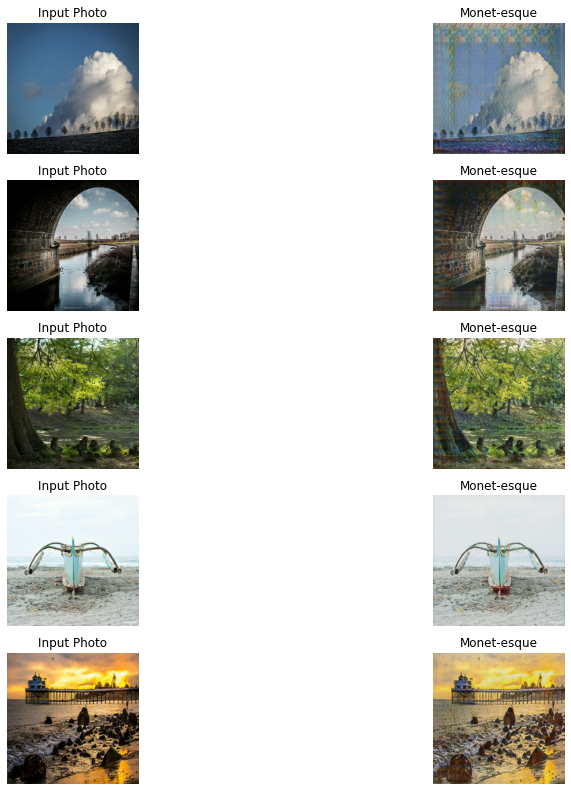

In [19]:
_, ax = plt.subplots(5, 2, figsize=(14, 14))
for i, img in enumerate(PhotoDS.take(5)):
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

#### Conclusion:

The submisson score (FID) is about 63.8, which is around #70 of the leaderboard at the time of submission. Over all, this project demonstrated an introduction into GANs by transforming images into Monet-esque paintings using CycleGAN (a common algorithm for transforming images).

In [20]:
import PIL
! mkdir ../images

In [22]:
i = 1
for img in PhotoDS:
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

2023-01-09 11:33:52.818285: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 2789817, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673264032.818032102","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 2789817, Output num: 0","grpc_status":3}


In [23]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'